In [316]:
!pip install optuna


  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/15/da/68883911855d8b4d521f9a370e4e6aab8232b91c1d8d5a8348c4680c6642/optuna-3.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for alembic>=1.5.0 from https://files.pythonhosted.org/packages/df/ed/c884465c33c25451e4a5cd4acad154c29e5341e3214e220e7f3478aa4b0d/alembic-1.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for colorlog from https://files.pythonhosted.org/packages/f3/18/3e867ab37a24fdf073c1617b9c7830e06ec270b1ea4694a624038fc40a03/colorlog-6.8.2-py3-none-any.whl.metadata
  Obtaining dependency information for Mako from https://files.pythonhosted.org/packages/03/62/70f5a0c2dd208f9f3f2f9afd103aec42ee4d9ad2401d78342f75e9b8da36/Mako-1.3.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/380.1 kB 991.0 kB/s eta 0:00:01
   ---- ---------------------------------- 41.0/380

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import optuna
from optuna import Trial, visualization
from sklearn.metrics import accuracy_score

In [19]:
data = pd.read_csv('./csv/data.csv')


In [20]:
data.isna().any()

match id                    False
team1                       False
team1_id                    False
team1_roster_ids            False
team2                       False
                            ...  
team_ratio_bat_form         False
team_ratio_bowl_form        False
team_ratio_last5_avg        False
team_ratio_last5_eco_top    False
team_ratio_last5_eco_bot    False
Length: 98, dtype: bool

In [21]:
data=data.fillna(0)
# filling data with 0 will not hv a larger effect \
# as while developing features for players for which data is not available has been ignored

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 98 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   match id                   948 non-null    int64  
 1   team1                      948 non-null    int64  
 2   team1_id                   948 non-null    int64  
 3   team1_roster_ids           948 non-null    object 
 4   team2                      948 non-null    int64  
 5   team2_id                   948 non-null    int64  
 6   team2_roster_ids           948 non-null    object 
 7   winner                     948 non-null    int64  
 8   winner_id                  948 non-null    int64  
 9   toss winner                948 non-null    int64  
 10  toss decision              948 non-null    int64  
 11  venue                      948 non-null    int64  
 12  city                       948 non-null    int64  
 13  match_dt                   948 non-null    object 

In [23]:
features = [
    'match id', 'team1',  'team2', 'toss winner', 'toss decision', 'venue', 'city',  'lighting', 
    'series_name', 'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5', 
    'team1only_avg_runs_last15', 'team1_winp_team2_last15', 'ground_avg_runs_last15', 'year', 'month', 
    'day', 'team1_top4_avg', 'team2_top4_avg', 'team1_top4_bats', 'team2_top4_bats', 'team1_top4_eco', 
    'team2_top4_eco', 'team1_bot4_eco', 'team2_bot4_eco', 'team1_top2_wck', 'team2_top2_wck', 
    'team1_avg_top4_ag', 'team2_avg_top4_ag', 'team1_eco_bot4_ag', 'team2_eco_bot4_ag', 'team1_eco_top4_ag', 
    'team2_eco_top4_ag', 'team1_wck_top2_ag', 'team2_wck_top2_ag', 'team1_avg_top4_ve', 'team2_avg_top4_ve', 
    'team1_eco_top4_ve', 'team2_eco_top4_ve', 'team1_eco_bot4_ve', 'team2_eco_bot4_ve', 'team1_wck_top2_ve', 
    'team2_wck_top2_ve', 'team1_count_rel_bats', 'team2_count_rel_bats', 'team1_count_rel_bowl', 
    'team2_count_rel_bowl', 'team1_avg_top4_in', 'team2_avg_top4_in', 'team1_eco_top4_in', 
    'team2_eco_top4_in', 'team1_eco_bot4_in', 'team2_eco_bot4_in', 'team1_wck_top2_in', 'team2_wck_top2_in', 
    'team1_count_bat_form', 'team2_count_bat_form', 'team1_last5_avg', 'team2_last5_avg', 
    'team1_last5_eco_top', 'team2_last5_eco_top', 'team1_last5_eco_bot', 'team2_last5_eco_bot', 
    'team1_count_bowl_form', 'team2_count_bowl_form', 'team_ratio_avg', 'team_ratio_bats', 
    'team_ratio_eco_top', 'team_ratio_eco_bot', 'team_ratio_wck', 'team_ratio_avg_ag', 'team_ratio_avg_ve', 
    'team_ratio_avg_in', 'team_ratio_eco_top_ag', 'team_ratio_eco_top_ve', 'team_ratio_eco_top_in', 
    'team_ratio_eco_bot_ag', 'team_ratio_eco_bot_ve', 'team_ratio_eco_bot_in', 'team_ratio_wck_top_ag', 
    'team_ratio_wck_top_ve', 'team_ratio_wck_top_in', 'team_ratio_rel_bats', 'team_ratio_rel_bowl', 
    'team_ratio_bat_form', 'team_ratio_bowl_form', 'team_ratio_last5_avg', 'team_ratio_last5_eco_top', 
    'team_ratio_last5_eco_bot'
]


In [26]:
y=data['winner']
x=data[features]

For k=1, GBM mean cross-validated accuracy: 0.6729935950988583
For k=2, GBM mean cross-validated accuracy: 0.7173210804789752
For k=3, GBM mean cross-validated accuracy: 0.72890559732665
For k=4, GBM mean cross-validated accuracy: 0.7542690058479533
For k=5, GBM mean cross-validated accuracy: 0.7479197994987469
For k=6, GBM mean cross-validated accuracy: 0.754235588972431
For k=7, GBM mean cross-validated accuracy: 0.7531662489557226
For k=8, GBM mean cross-validated accuracy: 0.7647730437204122
For k=9, GBM mean cross-validated accuracy: 0.7616040100250626
For k=10, GBM mean cross-validated accuracy: 0.7647619047619048
For k=11, GBM mean cross-validated accuracy: 0.7647674742411585
For k=12, GBM mean cross-validated accuracy: 0.7763631300473406
For k=13, GBM mean cross-validated accuracy: 0.7605792258423837
For k=14, GBM mean cross-validated accuracy: 0.78901141743247
For k=15, GBM mean cross-validated accuracy: 0.7805959342801448
For k=16, GBM mean cross-validated accuracy: 0.7785073

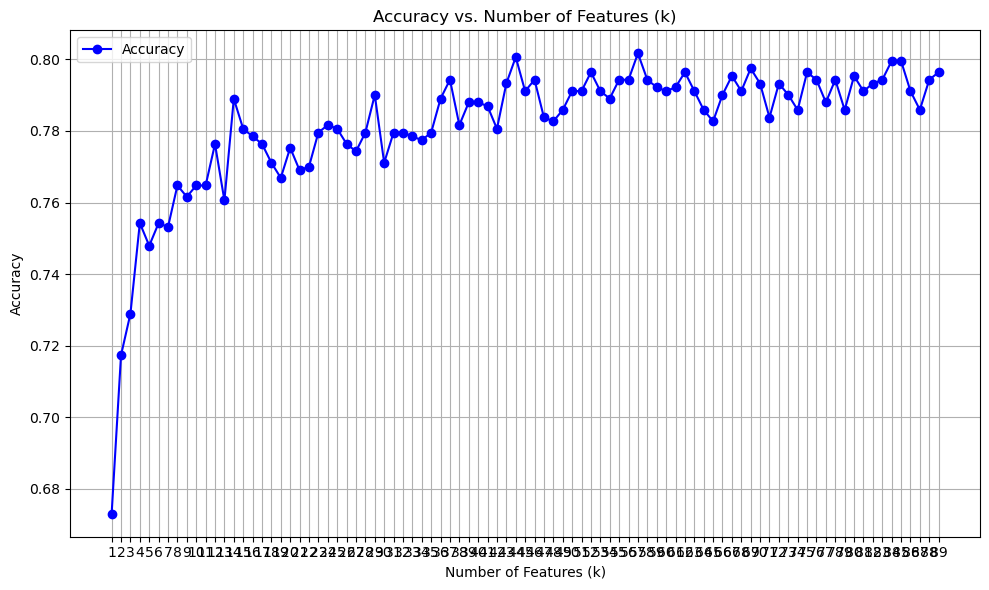

In [28]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import StratifiedKFold



# Assuming X and y are your features and target variable before splitting

k_values = range(1, 90)  # Start from 1 up to 25

# Store accuracy scores for different k values
accuracy_scores = []

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for k in k_values:
    # Store scores for the current k
    cv_scores = []

    for train_index, val_index in cv.split(x, y):
        X_train, X_val = x.iloc[train_index], x.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit SelectKBest with mutual_info_regression and k
        sel_k_cols = SelectKBest(mutual_info_regression, k=k)
        sel_k_cols.fit(X_train, y_train)
        mask = sel_k_cols.get_support()

        # Update X_train and X_val to only contain the selected features
        X_train_selected = X_train.loc[:, mask]
        X_val_selected = X_val.loc[:, mask]

        # Train GBM
        gbm = GradientBoostingClassifier(random_state=0)
        gbm.fit(X_train_selected, y_train)

        # Predict on validation set
        y_pred_gbm = gbm.predict(X_val_selected)

        # Calculate accuracy and store it
        accuracy = accuracy_score(y_val, y_pred_gbm)
        cv_scores.append(accuracy)

    # Store the mean accuracy for the current k
    mean_accuracy = np.mean(cv_scores)
    accuracy_scores.append(mean_accuracy)
    print(f'For k={k}, GBM mean cross-validated accuracy: {mean_accuracy}')

# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Accuracy vs. Number of Features (k)')
plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# highest: For k=57, GBM mean cross-validated accuracy: 0.8017098301308827

In [29]:
from sklearn.feature_selection import SelectKBest

sel_k_cols = SelectKBest(mutual_info_regression, k=57)
sel_k_cols.fit(x, y)
mask = sel_k_cols.get_support()

# Update X_train to only contain the selected features
x_selected = x.loc[:, mask]
# X_train_selected

# If you also want to transform the test set, use the same mask

In [30]:
gbm = GradientBoostingClassifier()
scores = cross_val_score(gbm, x_selected, y, cv=5, scoring='accuracy')

In [31]:
scores.mean()
# 0.8070119743803954

0.8070119743803954

In [ ]:
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [3, 5, 7, 9, 11, 13],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'subsample': [0.8, 0.9, 1.0]
}

random_search = RandomizedSearchCV(estimator=gbm, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(x_selected, y)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(random_search.best_score_))

In [345]:
import optuna
from optuna import Trial, visualization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

def objective(trial: Trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0)
    }

    gbm = GradientBoostingClassifier(**param)
    
    # Using cross-validation to get the average accuracy score
    accuracy = cross_val_score(gbm, x_selected, y, cv=5, scoring='accuracy').mean()
    
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-06-29 05:46:59,969] A new study created in memory with name: no-name-d67bef78-a7b2-4c4c-98e8-d20093f20f33
[I 2024-06-29 05:47:33,320] Trial 0 finished with value: 0.7717845939351691 and parameters: {'n_estimators': 287, 'learning_rate': 0.3492995106497918, 'max_depth': 15, 'min_samples_split': 49, 'min_samples_leaf': 16, 'subsample': 0.6566248528760917}. Best is trial 0 with value: 0.7717845939351691.
[I 2024-06-29 05:47:50,123] Trial 1 finished with value: 0.7915214360404321 and parameters: {'n_estimators': 77, 'learning_rate': 0.2957052479726203, 'max_depth': 6, 'min_samples_split': 23, 'min_samples_leaf': 4, 'subsample': 0.9044505928064682}. Best is trial 1 with value: 0.7915214360404321.
[I 2024-06-29 05:48:27,654] Trial 2 finished with value: 0.7928459393516905 and parameters: {'n_estimators': 196, 'learning_rate': 0.010944198283871316, 'max_depth': 5, 'min_samples_split': 22, 'min_samples_leaf': 4, 'subsample': 0.8453301904074836}. Best is trial 2 with value: 0.7928459393

Best trial:
  Value: 0.8100121993726038
  Params: 
    n_estimators: 173
    learning_rate: 0.018465345131470794
    max_depth: 4
    min_samples_split: 14
    min_samples_leaf: 4
    subsample: 0.6055041907468286
